In [56]:
%load_ext autoreload
%autoreload 2

import sys, os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from loss import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.nn import Parameter
import math
import torch.nn as nn

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [58]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [59]:
class ArcFace(nn.Module):
    r"""Implement of ArcFace (https://arxiv.org/pdf/1801.07698v1.pdf):
        Args:
            in_features: size of each input sample
            out_features: size of each output sample
            device_id: the ID of GPU where the model will be trained by model parallel. 
                       if device_id=None, it will be trained on CPU without model parallel.
            s: norm of input feature
            m: margin
            cos(theta+m)
        """
    def __init__(self, in_features, out_features, s = 64.0, m = 0.50, easy_margin = False):
        super(ArcFace, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        self.s = s
        self.m = m
        
        self.kernel = Parameter(torch.FloatTensor(in_features, out_features))
        #nn.init.xavier_uniform_(self.kernel)
        nn.init.normal_(self.kernel, std=0.01)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, embbedings, label):
        embbedings = l2_norm(embbedings, axis = 1)
        kernel_norm = l2_norm(self.kernel, axis = 0)
        cos_theta = torch.mm(embbedings, kernel_norm)
        cos_theta = cos_theta.clamp(-1, 1)  # for numerical stability
        with torch.no_grad():
            origin_cos = cos_theta.clone()
        target_logit = cos_theta[torch.arange(0, embbedings.size(0)), label].view(-1, 1)

        sin_theta = torch.sqrt(1.0 - torch.pow(target_logit, 2))
        cos_theta_m = target_logit * self.cos_m - sin_theta * self.sin_m #cos(target+margin)
        if self.easy_margin:
            final_target_logit = torch.where(target_logit > 0, cos_theta_m, target_loit)
        else:
            final_target_logit = torch.where(target_logit > self.th, cos_theta_m, target_logit - self.mm)

        cos_theta.scatter_(1, label.view(-1, 1).long(), final_target_logit)
        output = cos_theta * self.s
        return output, origin_cos * self.s


def l2_norm(input, axis = 1):
    norm = torch.norm(input, 2, axis, True)
    output = torch.div(input, norm)

    return output

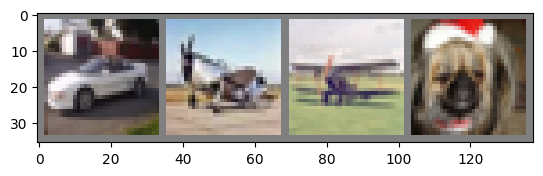

car   plane plane dog  


In [60]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [61]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        #self.fc3 = nn.Linear(84, 10)

        self.classifier = ArcFace(in_features=84, out_features=10)

    def forward(self, x, labels):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # 배치를 제외한 모든 차원을 평탄화(flatten)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
#         x = self.fc3(x)
        x= self.classifier(x,labels)
        return x


net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (classifier): ArcFace()
)

In [62]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [63]:
for epoch in range(2):   # 데이터셋을 수차례 반복합니다.

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data[0].to(device), data[1].to(device)

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs, origin_cos = net(inputs, labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 19.997
[1,  4000] loss: 16.983
[1,  6000] loss: 16.575
[1,  8000] loss: 16.345
[1, 10000] loss: 16.097
[1, 12000] loss: 15.866


KeyboardInterrupt: 